In [1]:
# Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ptsnet.simulation.sim import PTSNETSimulation
from ptsnet.utils.io import get_example_path, export_time_series
from utils import plot_comparison_results

In [5]:
# Constants

results_file = lambda f: os.path.join(os.getcwd(), 'results', f)
node_names = ['JUNCTION-30', 'JUNCTION-16', 'JUNCTION-20', 'JUNCTION-45', 'JUNCTION-90']

## Simulation Settings
Simulation settings can be defined using a dictionary. We show below the default simulation settings.

In [6]:
default_settings = {
    "time_step" : 0.01, # Simulation time step in [s]
    "duration" : 20, # Simulation duration in [s]
    "period" : 0, # Simulation period for EPS
    "default_wave_speed" : 1000, # Wave speed value for all pipes in [m/s]
    "wave_speed_file_path" : None, # Text file with wave speed values
    "delimiter" : ',', # Delimiter of text file with wave speed values
    "wave_speed_method" : 'optimal', # Wave speed adjustment method
    "save_results" : True, # Saves numerical results in HDF5 format
    "skip_compatibility_check" : False, # Dismisses compatibility check
    "show_progress" : False, # Shows progress (Warnings should be off)
    "profiler_on" : False, # Measures computational times of the simulation
    "warnings_on" : False # Warnings are displayed if True
}

## Running a Simulation
The function `PTSNETSimulation` creates a new PTSNET simulation that reads an input file (.inp) located in the path `inpfile` and parses it. Users can use the test cases provided by the library which include:
`["B0", "B0_SURGE", "B1_0", "B3", "B0_0", "B1_1", "B4", "PIPE_IN_SERIES", "TNET3", "B0_1", "B2", "LOOP"]`. Paths to the test cases can be extracted using the `get_example_path(ex_name)` function.

In [7]:
# Create a simulation
inpfile = get_example_path('TNET3')
print(f"Path to the input file: {inpfile}")
sim = PTSNETSimulation(
    workspace_name = "TNET3_SIM",
    inpfile = inpfile,
    settings = default_settings
    # If settings are not defined, default settings are loaded automatically
)
print(sim)

Path to the input file: /home/gandresr/Documents/GitHub/ptsnet/ptsnet/examples/TNET3.inp
PTSNETSimulation <duration = 20 [s] | time_steps = 2617 | num_points = 5,098>


## Valve Closure
Users can manipulate specific valves of the system via the `define_valve_operation` function. The function allows to manipulate one or many pipes (e.g., `sim.all_pipes`). By default the closure occurs linearly varying the setting of the valve.

In [8]:
sim = PTSNETSimulation(workspace_name = 'TNET3_VALVE', inpfile = get_example_path('TNET3'))
sim.define_valve_operation('VALVE-179', initial_setting=1, final_setting=0, start_time=1, end_time=2)
sim.run()

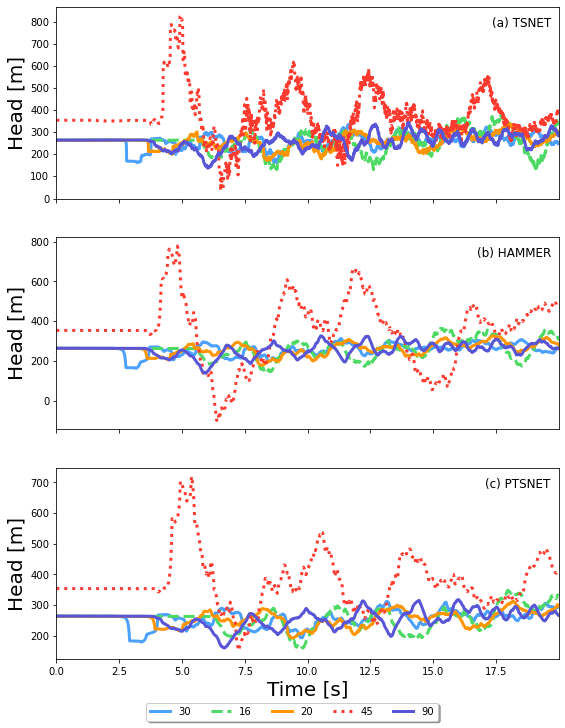

In [9]:
# Comparing Results

data = {node_name : sim['node'].head[node_name] for node_name in node_names}
export_time_series(sim['time'], data, path=results_file('valve_ptsnet.txt'))

plot_comparison_results(node_names,
    data_ptsnet = pd.read_csv(results_file('valve_ptsnet.txt')),
    data_tsnet = pd.read_csv(results_file('valve_tsnet.txt')),
    data_hammer = pd.read_csv(results_file('valve_hammer.txt')))

## Pump shut-off
Users can shut-off pumps using the `define_pump_operation`. By default the shut-off occurs linearly varying the setting of the pump.

In [10]:
sim = PTSNETSimulation(workspace_name = 'TNET3_PUMP', inpfile = get_example_path('TNET3'))
sim.define_pump_operation('PUMP-172', initial_setting=1, final_setting=0, start_time=0, end_time=1)
sim.run()

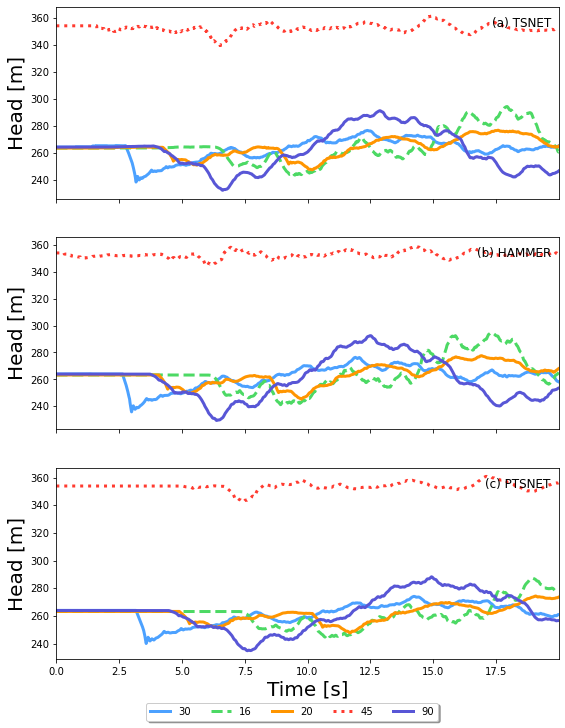

In [11]:
# Comparing Results

data = {node_name : sim['node'].head[node_name] for node_name in node_names}
export_time_series(sim['time'], data, path=results_file('pump_ptsnet.txt'))

plot_comparison_results(node_names,
    data_ptsnet = pd.read_csv(results_file('pump_ptsnet.txt')),
    data_tsnet = pd.read_csv(results_file('pump_tsnet.txt')),
    data_hammer = pd.read_csv(results_file('pump_hammer.txt')))

## Bursts
Users can add bursts defining `start_time` and `end_time` values which define how the burst is going to develop. Users have to define the final loss coefficient associated with the burst.

In [12]:
sim = PTSNETSimulation(workspace_name = 'TNET3_BURST', inpfile = get_example_path('TNET3'), settings={'duration':20})
sim.add_burst('JUNCTION-73', 0.02, 1, 2)
sim.run()

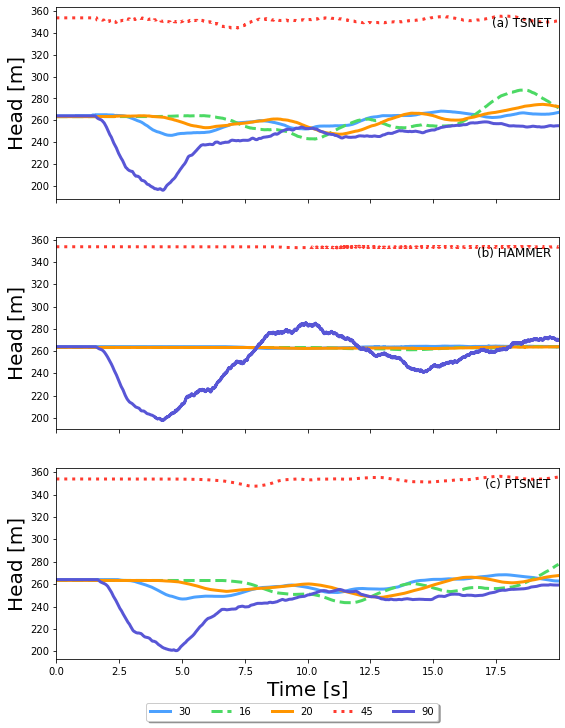

In [13]:
# Comparing Results

data = {node_name : sim['node'].head[node_name] for node_name in node_names}
export_time_series(sim['time'], data, path=results_file('burst_ptsnet.txt'))

plot_comparison_results(node_names,
    data_ptsnet = pd.read_csv(results_file('burst_ptsnet.txt')),
    data_tsnet = pd.read_csv(results_file('burst_tsnet.txt')),
    data_hammer = pd.read_csv(results_file('burst_hammer.txt')))

## Open Surge Tanks
We generate a transient by closing all the system's valves in 1 s. We add an open surge protection on node N7, with cross-section area, $A_T = 0.1$ $\text{m}^2$

In [14]:
sim = PTSNETSimulation(workspace_name = 'TNET3_OPEN_SURGE', inpfile = get_example_path('TNET3'))
sim.define_pump_operation('PUMP-172', initial_setting=1, final_setting=0, start_time=0, end_time=1)
sim.add_surge_protection('JUNCTION-34', 'open', 0.1)
sim.run()

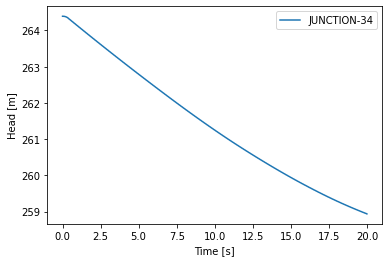

In [15]:
plt.plot(sim['time'], sim['node'].head['JUNCTION-34'], label='JUNCTION-34')
plt.xlabel('Time [s]'); plt.ylabel('Head [m]')
plt.legend()
plt.show()

## Closed Surge Tanks
We generate a transient by closing all the system's valves in 1 s. We add an closed surge protection on node N7, with cross-section area $A_T = 0.1 \text{ m}^2$, height $H_T = 1 \text{ m}$, and initial water level $H_W = 0.2\text{ m}$.

In [16]:
sim = PTSNETSimulation(workspace_name = 'TNET3_CLOSED_SURGE', inpfile = get_example_path('TNET3'))
sim.define_pump_operation('PUMP-172', initial_setting=1, final_setting=0, start_time=0, end_time=1)
sim.add_surge_protection('JUNCTION-34', 'closed', 0.1, 0.24, 0.2)
sim.run()

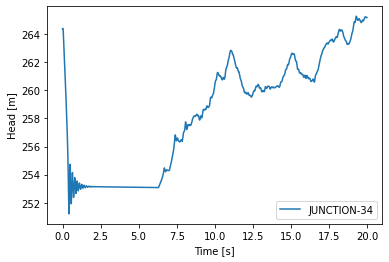

In [17]:
plt.plot(sim['time'], sim['node'].head['JUNCTION-34'], label='JUNCTION-34')
plt.xlabel('Time [s]'); plt.ylabel('Head [m]')
plt.legend()
plt.show()

### Valve Opening

In [35]:
sim = PTSNETSimulation(workspace_name = 'VALVE_OPENING', inpfile = get_example_path('B0_0'))
sim.define_valve_operation('V1', initial_setting=0, final_setting=1, start_time=0, end_time=1)
sim.run()

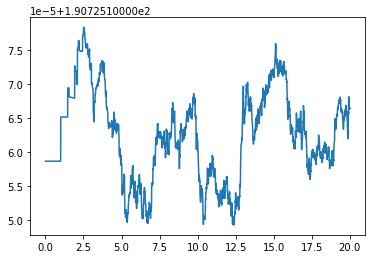

In [37]:
plt.plot(sim['time'], sim['node'].head['V1-B'])
plt.show()

### Variable Demand

Users can define arbitrary demand patterns for nodes

In [31]:
sim = PTSNETSimulation(workspace_name = 'VALVE_OPENING', inpfile = get_example_path('B0_0'))
sim.define_valve_operation('V1', initial_setting=0, final_setting=1, start_time=0, end_time=1)
sim.define_demand_settings('N3', X=np.linspace(0,20,100), Y=np.random.rand(100)*0.01)
sim.run()

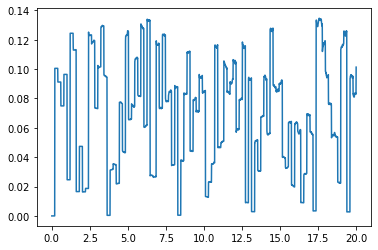

In [32]:
plt.plot(sim['time'], sim['node'].demand_flow['N3'])
plt.show()